In [35]:
import dgl

import torch
import torch.nn as nn

import networkx as nx

from data import pert_S

from arch.model import RobustGNNModel1, RobustGNNModel2

from dgl.nn import GATConv, GraphConv

import numpy as np

import matplotlib.pyplot as plt

In [36]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [37]:
def get_data(dataset_class):
    dataset = getattr(dgl.data, dataset_class)(verbose=False)
    g = dataset[0]
    num_class = dataset.num_classes

    # get node feature
    feat = g.ndata['feat'].to(device)

    # get data split
    train_mask = g.ndata['train_mask'].to(device)
    val_mask = g.ndata['val_mask'].to(device)
    test_mask = g.ndata['test_mask'].to(device)

    # get labels
    label = g.ndata['label'].to(device)
    N = g.number_of_nodes()
    n_feat = feat.shape[1]

    S = g.adj().to_dense().numpy()

    return S, feat, label, n_feat, num_class, train_mask, val_mask, test_mask

In [38]:
S, feat, label, n_feat, num_class, train_mask, val_mask, test_mask = get_data("CoraGraphDataset")

In [39]:
n_epochs = 50
lr = 5e-3
wd = 5e-4
eval_freq = 50

lr_S = 10.

n_iters = 40
n_iters_S = 50

hid_dim = 16
n_layers = 2
model_params = {
    'in_dim': n_feat,
    'hid_dim': hid_dim,
    'out_dim': num_class,
    'n_layers': n_layers,
    'K': 2
}

model_params_m2 = {
    'in_dim': n_feat,
    'hid_dim': hid_dim,
    'out_dim': num_class,
    'n_layers': n_layers
}

gamma = 0.1
beta = 0.01
lambd = .001

In [40]:
S = torch.Tensor(S).to(device)

eps = 0.1
Sn = torch.Tensor(pert_S(S.cpu().numpy(), eps=eps)).to(device)

In [41]:
model = RobustGNNModel1(Sn, n_epochs, lr, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="clas")
model.model = model.model.to(device)

accs_train_m1, accs_test_m1, S_id_m1, errs_S_m1, change_S_m1 = model.test_model(Sn, feat, label, gamma, lambd, beta, train_idx=train_mask, val_idx=val_mask, test_idx=test_mask, S_true=S, verbose=True)

Iteration 1 DONE - Acc Test: 0.687 - Err S: 0.44639113545417786
Iteration 2 DONE - Acc Test: 0.7 - Err S: 0.44648149609565735
Iteration 3 DONE - Acc Test: 0.698 - Err S: 0.44665172696113586
Iteration 4 DONE - Acc Test: 0.705 - Err S: 0.44678428769111633
Iteration 5 DONE - Acc Test: 0.714 - Err S: 0.4468880593776703
Iteration 6 DONE - Acc Test: 0.718 - Err S: 0.4469667971134186
Iteration 7 DONE - Acc Test: 0.719 - Err S: 0.4470265507698059
Iteration 8 DONE - Acc Test: 0.72 - Err S: 0.44706910848617554
Iteration 9 DONE - Acc Test: 0.723 - Err S: 0.4470957815647125
Iteration 10 DONE - Acc Test: 0.722 - Err S: 0.44710907340049744
Iteration 11 DONE - Acc Test: 0.726 - Err S: 0.44711413979530334
Iteration 12 DONE - Acc Test: 0.726 - Err S: 0.44711580872535706
Iteration 13 DONE - Acc Test: 0.724 - Err S: 0.44711434841156006
Iteration 14 DONE - Acc Test: 0.725 - Err S: 0.44710972905158997
Iteration 15 DONE - Acc Test: 0.728 - Err S: 0.4471016526222229
Iteration 16 DONE - Acc Test: 0.729 - Err 

In [42]:
lr_gcn = 5e-2
n_epochs_gcn = n_epochs*n_iters

In [43]:
model = RobustGNNModel1(Sn, n_epochs_gcn, lr_gcn, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="clas")
model.model = model.model.to(device)

acc_train_gcn, acc_val_gcn, acc_test_gcn, losses_gcn = model.stepH(feat, label, train_mask, val_mask, test_mask, verbose=True)

Epoch 1/2000 - Loss: 6.135286808013916 - Train Acc: 0.17857142857142858 - Test Acc: 0.135
Epoch 50/2000 - Loss: 0.01376155111938715 - Train Acc: 1.0 - Test Acc: 0.724
Epoch 100/2000 - Loss: 0.007844901643693447 - Train Acc: 1.0 - Test Acc: 0.719
Epoch 150/2000 - Loss: 0.005180537700653076 - Train Acc: 1.0 - Test Acc: 0.727
Epoch 200/2000 - Loss: 0.003933367785066366 - Train Acc: 1.0 - Test Acc: 0.723
Epoch 250/2000 - Loss: 0.003226984990760684 - Train Acc: 1.0 - Test Acc: 0.726
Epoch 300/2000 - Loss: 0.0027751843445003033 - Train Acc: 1.0 - Test Acc: 0.726
Epoch 350/2000 - Loss: 0.002460289280861616 - Train Acc: 1.0 - Test Acc: 0.727
Epoch 400/2000 - Loss: 0.002246726769953966 - Train Acc: 1.0 - Test Acc: 0.733
Epoch 450/2000 - Loss: 0.002086763270199299 - Train Acc: 1.0 - Test Acc: 0.738
Epoch 500/2000 - Loss: 0.0019625553395599127 - Train Acc: 1.0 - Test Acc: 0.739
Epoch 550/2000 - Loss: 0.0018633712315931916 - Train Acc: 1.0 - Test Acc: 0.74
Epoch 600/2000 - Loss: 0.0017821090295910

# Start of model 2

In [48]:
model = RobustGNNModel2(Sn, n_epochs, lr, wd, lr_S, eval_freq, model_params_m2, n_iters, n_iters_S, problem_type="clas")
model.model = model.model.to(device)

accs_train_m2, accs_test_m2, S_id_m2, errs_S_m2, change_S_m2 = model.test_model(Sn, feat, label, gamma, lambd, beta, train_idx=train_mask, val_idx=val_mask, test_idx=test_mask, S_true=S, verbose=True)

Iteration 1 DONE - Acc Test: 0.387 - Err S: 22.23170280456543
Iteration 2 DONE - Acc Test: 0.348 - Err S: 22.14261817932129
Iteration 3 DONE - Acc Test: 0.316 - Err S: 20.85991096496582
Iteration 4 DONE - Acc Test: 0.311 - Err S: 15.489672660827637
Iteration 5 DONE - Acc Test: 0.293 - Err S: 7.471167087554932
Iteration 6 DONE - Acc Test: 0.28 - Err S: 1.0616650581359863
Iteration 7 DONE - Acc Test: 0.276 - Err S: 0.9598397612571716
Iteration 8 DONE - Acc Test: 0.207 - Err S: 0.9362067580223083
Iteration 9 DONE - Acc Test: 0.12 - Err S: 0.923152506351471
Iteration 10 DONE - Acc Test: 0.104 - Err S: 0.9124895334243774
Iteration 11 DONE - Acc Test: 0.103 - Err S: 0.9027171730995178
Iteration 12 DONE - Acc Test: 0.103 - Err S: 0.8932945728302002
Iteration 13 DONE - Acc Test: 0.103 - Err S: 0.8842041492462158
Iteration 14 DONE - Acc Test: 0.064 - Err S: 0.8764083981513977
Iteration 15 DONE - Acc Test: 0.103 - Err S: 24.121109008789062
Iteration 16 DONE - Acc Test: 0.103 - Err S: 22.70213699

# Representation

In [49]:
accs_test_gcn = []
for i in range(n_iters):
    accs_test_gcn.append(acc_test_gcn[(i+1)*n_epochs-1])

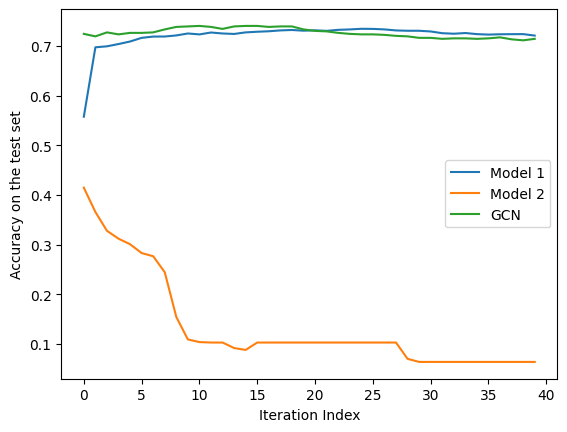

In [50]:
plt.plot(accs_test_m1.mean(1), label="Model 1")
plt.plot(accs_test_m2.mean(1), label="Model 2")
plt.plot(accs_test_gcn, label="GCN")

plt.xlabel("Iteration Index")
plt.ylabel("Accuracy on the test set")

plt.legend()

(0.45, 0.8)

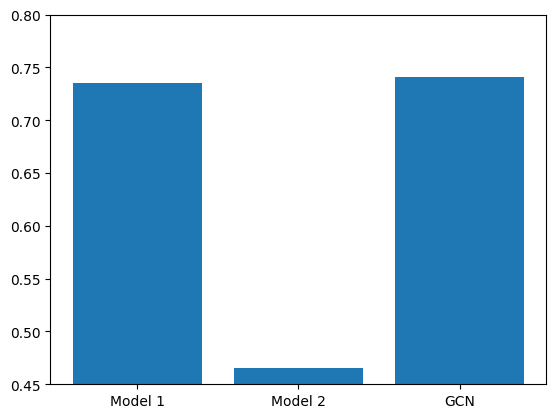

In [51]:
plt.bar(np.arange(3), [acc.max() for acc in [accs_test_m1, accs_test_m2, acc_test_gcn]])
plt.xticks(np.arange(3), ["Model 1", "Model 2", "GCN"])
plt.ylim([0.45,0.8])

# Exhaustive experiments

In [53]:
eps = 0.1
n_graphs = 10

accs_test_m1 = np.zeros((n_graphs, n_iters, n_epochs))
accs_test_m2 = np.zeros((n_graphs, n_iters, n_epochs))
accs_test_gcn = np.zeros((n_graphs, n_iters*n_epochs))

for n in range(n_graphs):
    print(f"{n+1} ", end="")
    Sn = torch.Tensor(pert_S(S.cpu().numpy(), eps=eps)).to(device)

    model = RobustGNNModel1(Sn, n_epochs, lr, wd, lr_S, eval_freq,
                            model_params, n_iters, n_iters_S, problem_type="clas")
    model.model = model.model.to(device)

    _, accs_test_m1[n,:,:], _, _, _ = model.test_model(
        Sn, feat, label, gamma, lambd, beta, 
        train_idx=train_mask, val_idx=val_mask, test_idx=test_mask, 
        S_true=S, verbose=False
    )

    model = RobustGNNModel1(Sn, n_epochs_gcn, lr_gcn, wd, lr_S, eval_freq,
                            model_params, n_iters, n_iters_S, problem_type="clas")
    model.model = model.model.to(device)

    _, _, accs_test_gcn[n,:], _ = model.stepH(
        feat, label, train_mask, val_mask, test_mask, verbose=False
    )

    model = RobustGNNModel2(Sn, n_epochs, lr, wd, lr_S, eval_freq,
                            model_params_m2, n_iters, n_iters_S, problem_type="clas")
    model.model = model.model.to(device)

    _, accs_test_m2[n,:,:], _, _, _ = model.test_model(
        Sn, feat, label, gamma, lambd, beta,
        train_idx=train_mask, val_idx=val_mask, test_idx=test_mask,
        S_true=S, verbose=False
    )

1 2 

In [ ]:
plt.plot(accs_test_m1.mean(0).flatten(), label="Model 1")
plt.plot(accs_test_m2.mean(0).flatten(), label="Model 1")
plt.plot(accs_test_gcn.mean(0), label="GCN")

plt.xlabel("Evolution of training process")
plt.ylabel("Accuracy on the test set")

In [ ]:
perts = [0., 0.1, 0.2, 0.3]
n_graphs = 5

accs_test_m1 = np.zeros((len(perts), n_graphs, n_iters, n_epochs))
accs_test_m2 = np.zeros((len(perts), n_graphs, n_iters, n_epochs))
accs_test_gcn = np.zeros((len(perts), n_graphs, n_iters*n_epochs))

for i, p in enumerate(perts):

    print(f"Starting pert {p}: ", end="")

    for n in range(n_graphs):
        print(f"{n+1} ", end="")
        Sn = torch.Tensor(pert_S(S.cpu().numpy(), eps=eps)).to(device)

        model = RobustGNNModel1(Sn, n_epochs, lr, wd, lr_S, eval_freq,
                                model_params, n_iters, n_iters_S, problem_type="clas")
        model.model = model.model.to(device)

        _, accs_test_m1[i,n,:,:], _, _, _ = model.test_model(
            Sn, feat, label, gamma, lambd, beta, 
            train_idx=train_mask, val_idx=val_mask, test_idx=test_mask, 
            S_true=S, verbose=False
        )

        model = RobustGNNModel1(Sn, n_epochs_gcn, lr_gcn, wd, lr_S, eval_freq,
                                model_params, n_iters, n_iters_S, problem_type="clas")
        model.model = model.model.to(device)

        _, _, accs_test_gcn[i,n,:], _ = model.stepH(
            feat, label, train_mask, val_mask, test_mask, verbose=False
        )

        model = RobustGNNModel2(Sn, n_epochs, lr, wd, lr_S, eval_freq,
                                model_params_m2, n_iters, n_iters_S, problem_type="clas")
        model.model = model.model.to(device)

        _, accs_test_m2[i,n,:,:], _, _, _ = model.test_model(
            Sn, feat, label, gamma, lambd, beta,
            train_idx=train_mask, val_idx=val_mask, test_idx=test_mask,
            S_true=S, verbose=False
        )

In [ ]:
plt.plot(accs_test_m1.mean(1).reshape((len(perts), -1).max(1)), label="Model 1")
plt.plot(accs_test_m2.mean(1).reshape((len(perts), -1).max(1)), label="Model 1")
plt.plot(accs_test_gcn.mean(1).max(1), label="GCN")

plt.xlabel("Perturbation")
plt.xticks(perts, perts)
plt.ylabel("Accuracy on the test set")

# Other GNN testing - For Future comparison

In [27]:
def evaluate(g, features, labels, mask, model):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

def test(model, g, feat, label, train_mask, val_mask, test_mask, verbose=True):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    loss_fn = torch.nn.CrossEntropyLoss()

    loss_train, acc_train, acc_test = [torch.zeros(n_epochs) for _ in range(3)]

    for i in range(n_epochs):
        model.train()
        y_hat = model(g, feat)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = loss_fn(y_hat[train_mask], label[train_mask])

        opt.zero_grad()
        loss.backward()
        opt.step()

        # Compute accuracy on training/validation/test
        train_acc = evaluate(g, feat, label, train_mask, model)
        val_acc = evaluate(g, feat, label, val_mask, model)
        test_acc = evaluate(g, feat, label, test_mask, model)

        loss_train[i] = loss.detach().cpu().item()
        acc_train[i] = train_acc
        acc_test[i] = test_acc

        if (i == 0 or (i+1) % eval_freq == 0) and verbose:
            print(f"Epoch {i+1}/{n_epochs} - Loss Train: {loss_train[i]} - Acc Train: {acc_train[i]} - Acc Val: {val_acc} - Acc Test: {acc_test[i]}", flush=True)

    return loss_train, acc_train, acc_test

In [28]:
hid_dim_gcn = 16

hid_dim_gat = 8
num_heads = 8
gat_params = {
    'feat_drop': 0.6,
    'attn_drop': 0.6
}

In [29]:
EXPS = [
    {
        "dataset": "Cora",
        "layer": "GCN",
        "legend": "Cora-GCN",
        "fmt": "d-"
    },
    {
        "dataset": "Citeseer",
        "layer": "GCN",
        "legend": "Citeseer-GCN",
        "fmt": "v-"
    },
    {
        "dataset": "Cora",
        "layer": "GAT",
        "legend": "Cora-GAT",
        "fmt": "s-"
    },
    {
        "dataset": "Citeseer",
        "layer": "GAT",
        "legend": "Citeseer-GAT",
        "fmt": "v-"
    },
]

In [30]:
class GAT(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads, gat_params):
        super(GAT, self).__init__()
        self.layer1 = GATConv(in_dim, hidden_dim, num_heads, **gat_params)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = GATConv(hidden_dim * num_heads, out_dim, 1, **gat_params)
        self.nonlin = nn.ELU()

    def forward(self, graph, h):
        h = self.layer1(graph, h)
        # concatenate
        h = h.flatten(1)
        h = self.nonlin(h)
        h = self.layer2(graph, h)
        return h.squeeze()

In [31]:
class GCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(GCN, self).__init__()
        self.layer1 = GraphConv(in_dim, hidden_dim)
        self.layer2 = GraphConv(hidden_dim, out_dim)
        self.nonlin = nn.Tanh()

    def forward(self, graph, h):
        h = self.layer1(graph, h)
        h = self.nonlin(h)
        h = self.layer2(graph, h)
        return h

In [32]:
perts = [0., 0.05, 0.1, 0.15, 0.2, 0.25]

n_graphs = 25

accs_test = np.zeros((n_graphs, len(EXPS), len(perts)))
for i, p in enumerate(perts):

    for j, exp in enumerate(EXPS):

        S, feat, label, in_dim, out_dim, train_mask, val_mask, test_mask = get_data(exp['dataset'] + "GraphDataset")

        print(f"Starting pert {p} of exp {exp['dataset']} - {exp['layer']}: ", end="")

        for n in range(n_graphs):
            print(f"{n+1} ", end="")
            
            S_pert = pert_S(S.copy(), eps=p)
            if p == 0.:
                assert np.all(S_pert == S)

            g = dgl.from_networkx(nx.from_numpy_array(S_pert)).add_self_loop().to(device)

            if exp['layer'] == "GCN":
                model = GCN(in_dim, hid_dim_gcn, out_dim).to(device)
            elif exp['layer'] == "GAT":
                model = GAT(in_dim, hid_dim_gat, out_dim, num_heads, gat_params).to(device)

            loss_train, acc_train, acc_test = test(model, g, feat, label, train_mask, val_mask, test_mask, False)

            accs_test[n, j, i] = acc_test[-1]
        print(f"DONE - Accuracy Test: {np.mean(accs_test, 0)[j,i]}")

Starting pert 0.0 of exp Cora - GCN: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 DONE - Accuracy Test: 0.7710000014305115
Starting pert 0.0 of exp Citeseer - GCN: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 DONE - Accuracy Test: 0.6723200058937073
Starting pert 0.0 of exp Cora - GAT: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 DONE - Accuracy Test: 0.8031599998474122
Starting pert 0.0 of exp Citeseer - GAT: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 DONE - Accuracy Test: 0.6993600010871888
Starting pert 0.05 of exp Cora - GCN: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 DONE - Accuracy Test: 0.755880000591278
Starting pert 0.05 of exp Citeseer - GCN: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 DONE - Accuracy Test: 0.6587599992752076
Starting pert 0.05 of exp Cora - GAT: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 DONE - Accuracy Tes

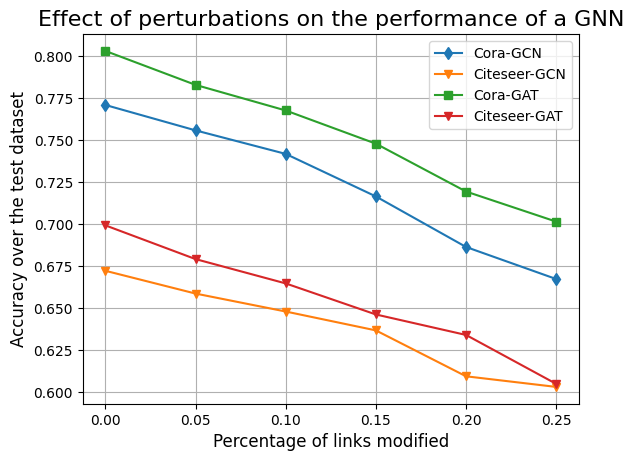

In [33]:
for i, exp in enumerate(EXPS):
    plt.plot(perts, accs_test.mean(0)[i,:], exp["fmt"], label=exp["legend"])

plt.xlabel("Percentage of links modified", fontsize=12)
plt.ylabel("Accuracy over the test dataset", fontsize=12)
plt.title("Effect of perturbations on the performance of a GNN", fontsize=16)
plt.legend()
plt.grid()